# <p style="background-color:#52bfad; font-family:newtimeroman; color:#262326; font-size:240%; text-align:center; border-radius:10px 10px;">Random Forest Classification: Banknote Authentication</p>

<div class="alert alert-block alert-success">
    
## <span style=" color:#bf2e98">About the Dataset

Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.  

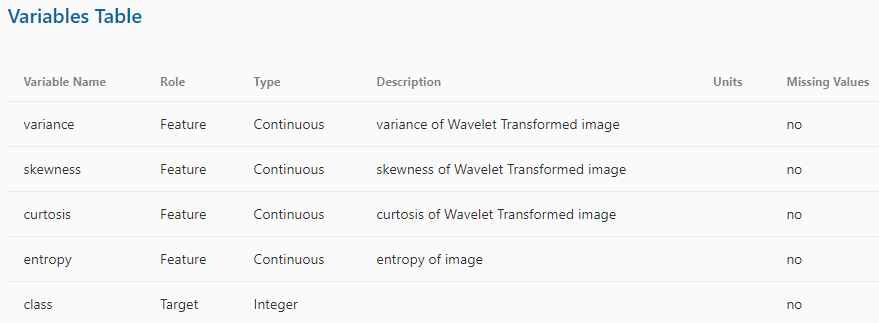

See: https://archive.ics.uci.edu/ml/datasets/banknote+authentication
</span>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data

In [2]:
df = pd.read_csv("data_banknote_authentication.csv")

In [3]:
df.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Image_Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Variance_Wavelet  1372 non-null   float64
 1   Skewness_Wavelet  1372 non-null   float64
 2   Curtosis_Wavelet  1372 non-null   float64
 3   Image_Entropy     1372 non-null   float64
 4   Class             1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


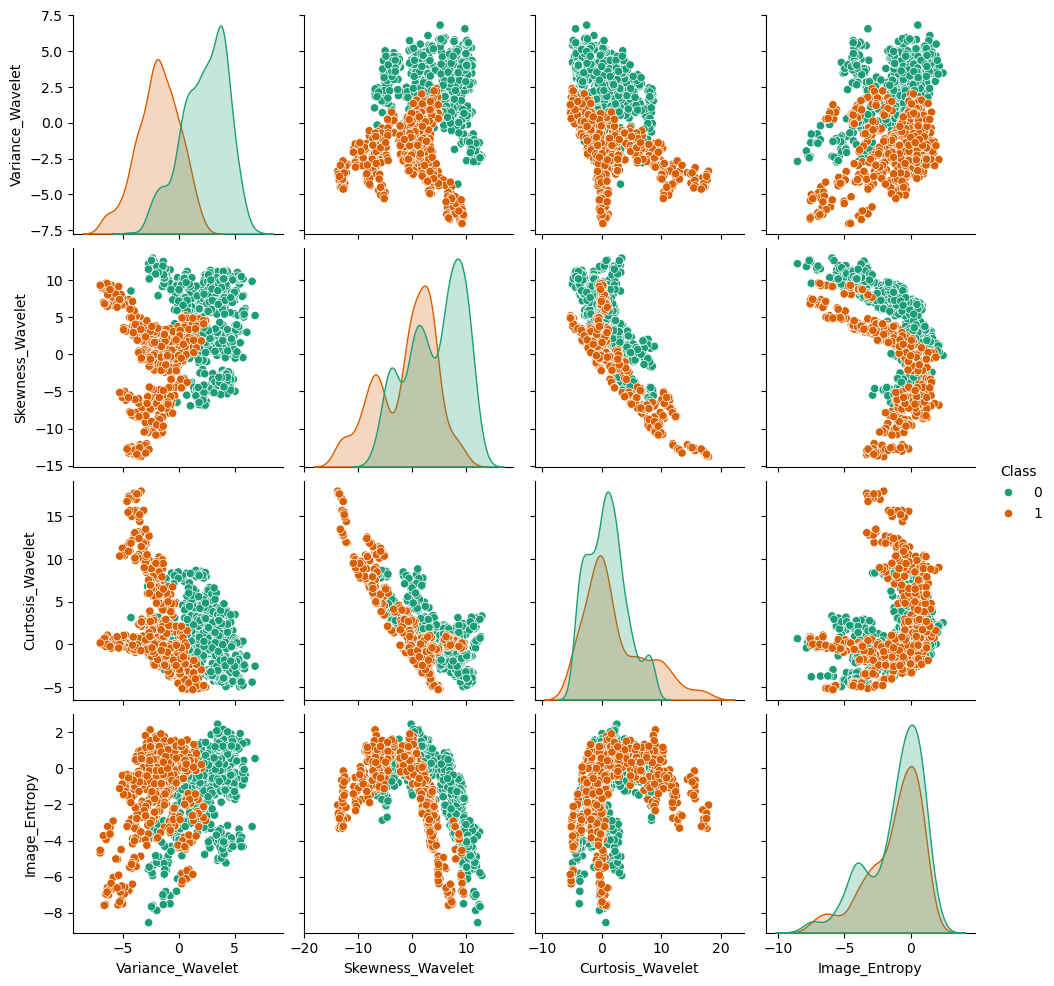

In [5]:
sns.pairplot(df, hue="Class", palette="Dark2");

## Train | Test Split

In [6]:
X = df.drop("Class",axis=1)
y = df["Class"]

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

## Random Forest Classification

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
# To see parameters see...
# help(RandomForestClassifier)

## Grid Search 

### Hyperparameters

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
# Parameters

n_estimators=[64,100,128,200]
max_features= [2,3,4]        # There are 4 features in the dataset
bootstrap = [True,False]
oob_score = [True,False]    # "oob_score" (out of bag estimation) only makes sense when bootstrap=True!

In [13]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'oob_score':oob_score} 

In [14]:
# RF Grid model

rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)

In [15]:
grid.fit(X_train,y_train)

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\admin\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    raise ValueError

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [64, 100, 128, 200],
                         'oob_score': [True, False]})

**Note:** It is normal to see warnings when "bootstrap=False" and "oob_score= True" because oob_score works under "bootstrap=True" condition. See: "ValueError: Out of bag estimation only available if bootstrap=True.
"

In [16]:
grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 100, 'oob_score': True}

The model chose 100 Trees.

In [17]:
predictions = grid.predict(X_test)

## Evaluation

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# To plot the confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

In [19]:
# Confusion Matrix
confusion_matrix(y_test,predictions)

array([[122,   2],
       [  0,  82]], dtype=int64)

There are only 2 misclassification.

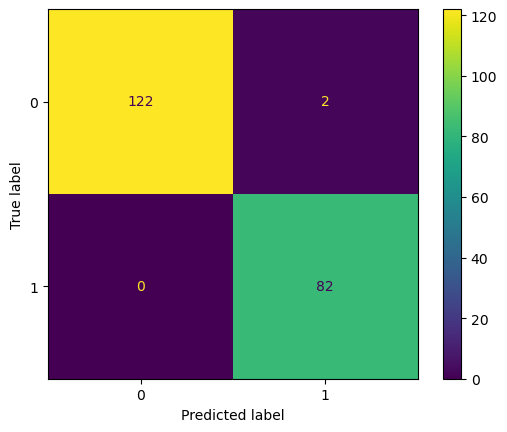

In [20]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions);

In [21]:
# Classification Report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       124
           1       0.98      1.00      0.99        82

    accuracy                           0.99       206
   macro avg       0.99      0.99      0.99       206
weighted avg       0.99      0.99      0.99       206



In [22]:
# No underscore, reports back original oob_score parameter
grid.best_estimator_.oob_score

True

In [23]:
# With underscore, reports back fitted attribute of oob_score
grid.best_estimator_.oob_score_

0.9948542024013722

oob_score result should be similar to accuracy.

### Understanding the Number of Estimators (Trees)

Let's plot out error vs. Number of Estimators

In [25]:
from sklearn.metrics import accuracy_score

In [28]:
errors = []
misclassifications = []

# from 1 to 200 estimators(trees)
for n in range(1,200): 
    rfc = RandomForestClassifier( n_estimators=n,bootstrap=True,max_features= 2)
    rfc.fit(X_train,y_train)
    preds = rfc.predict(X_test)
    err = 1 - accuracy_score(y_test, preds)
    n_missed = np.sum(preds != y_test)  # look for (2) misclassifications, (y_true is not equal to predictions)
    errors.append(err)
    misclassifications.append(n_missed)

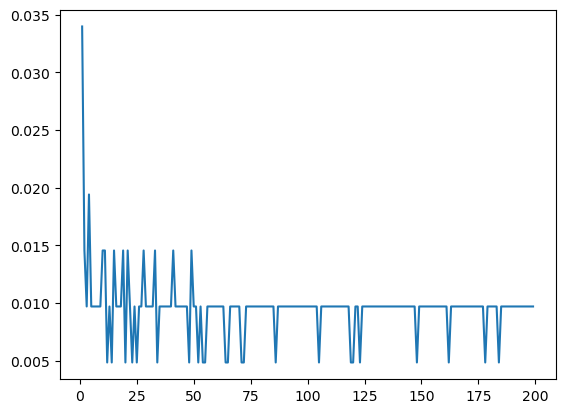

In [30]:
plt.plot(range(1,200),errors);

The plot shows that there is no need to choose high number of estimators/trees for the model because we cannot decrease the error after 50 estimators. It is important for model performance.

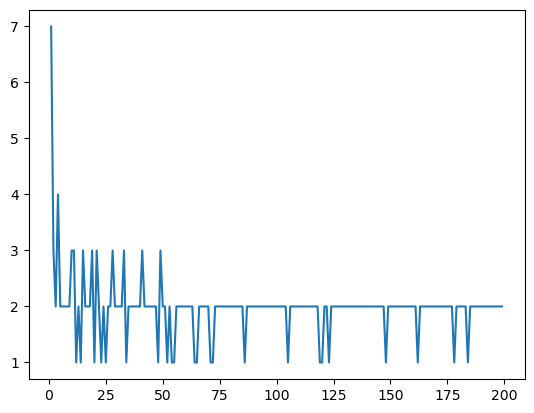

In [31]:
plt.plot(range(1,200),misclassifications);

Similarly, it could not decrease the number of misclassifications (2) after 50 estimators.